In [2]:
from pyspark.sql import SparkSession

spark = SparkSession \
        .builder \
        .appName("Twitter-Streaming") \
        .config("spark.sql.streaming.schemaInference", True) \
        .getOrCreate()

# Read parquet stream
df_stream = (
    spark
    .readStream
    .format("parquet")
    .load("twitter.parquet")
)

In [3]:
# Create dataframe grouping by window 
from pyspark.sql.functions import window, col, current_timestamp

df_count = (
    df_stream
    .withWatermark("tweet_created_at", "10 minutes") # Don't aggregate events arriving more than 10 minutes late
    .groupBy(
        window(col("tweet_created_at"), "10 minutes", "10 minutes"), # 10 minute window, updating every 10 minutes
        col("screen_name"))
    .count()
)

In [4]:
# Create query stream with memory sink
queryStream = (df_count
 .writeStream
 .format("memory")
 .queryName("twitter_changes")
 .outputMode("update")
 .start())

**********************
General Info
**********************
Run:3
Stream timestamp:2021-07-10T23:43:18.850Z
Watermark:2021-07-11T02:33:13.000Z
Total Rows:4110
Updated Rows:1
Memory used MB:1.272216
**********************
Graph - Top 10 users
**********************


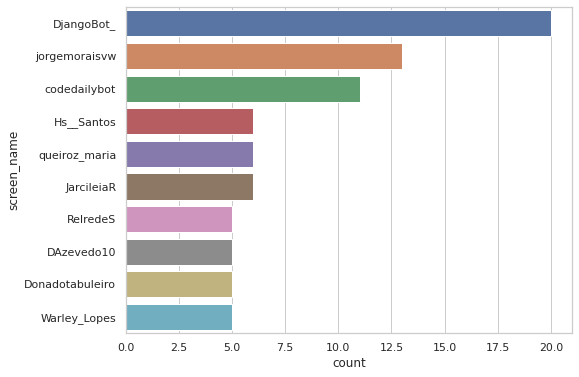

**********************
Table - Top 10 users
**********************


,start,end,screen_name,count
0,2021-07-10 23:40:00,2021-07-10 23:50:00,DjangoBot_,20
1,2021-07-10 23:40:00,2021-07-10 23:50:00,jorgemoraisvw,13
2,2021-07-10 23:40:00,2021-07-10 23:50:00,codedailybot,11
3,2021-07-10 23:40:00,2021-07-10 23:50:00,Hs__Santos,6
4,2021-07-10 23:40:00,2021-07-10 23:50:00,queiroz_maria,6
5,2021-07-10 23:40:00,2021-07-10 23:50:00,JarcileiaR,6
6,2021-07-10 23:40:00,2021-07-10 23:50:00,RelredeS,5
7,2021-07-10 23:40:00,2021-07-10 23:50:00,DAzevedo10,5
8,2021-07-10 23:40:00,2021-07-10 23:50:00,Donadotabuleiro,5
9,2021-07-10 23:40:00,2021-07-10 23:50:00,Warley_Lopes,5


**********************
Table - Count by aggregation window
**********************
process interrupted.


In [5]:
from time import sleep
from IPython.display import clear_output
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('font', family='DejaVu Sans')
sns.set(style="whitegrid")


try:
    i=1
    while True:
        # Clear output
        clear_output(wait=True)
        print("**********************")
        print("General Info")
        print("**********************")
        print("Run:{}".format(i))
        if (len(queryStream.recentProgress) > 0):
            print("Stream timestamp:{}".format(queryStream.lastProgress["timestamp"]))
            print("Watermark:{}".format(queryStream.lastProgress["eventTime"]["watermark"]))
            print("Total Rows:{}".format(queryStream.lastProgress["stateOperators"][0]["numRowsTotal"]))
            print("Updated Rows:{}".format(queryStream.lastProgress["stateOperators"][0]["numRowsUpdated"]))
            print("Memory used MB:{}".format((queryStream.lastProgress["stateOperators"][0]["memoryUsedBytes"]) * 0.000001))
            
        df = spark.sql(
                """
                    select
                        window.start
                        ,window.end
                        ,screen_name
                        ,sum(count) count
                    from
                        twitter_changes
                    where
                        window.start = (select max(window.start) from twitter_changes)
                    group by
                        window.start
                        ,window.end
                        ,screen_name
                    order by
                        4 desc
                    limit 10
                """
        ).toPandas()

        # Plot the total crashes
        sns.set_color_codes("muted")

        # Initialize the matplotlib figure
        plt.figure(figsize=(8,6))

        print("**********************")
        print("Graph - Top 10 users")
        print("**********************")
        try:
            # Barplot
            sns.barplot(x="count", y="screen_name", data=df)

            # Show barplot
            plt.show()
        except ValueError:
            # If Dataframe is empty, pass
            pass

        print("**********************")
        print("Table - Top 10 users")
        print("**********************")
        display(df)
        
        print("**********************")
        print("Table - Count by aggregation window")
        print("**********************")
        df1 = spark.sql(
                """
                    select
                        window.start
                        ,window.end
                        ,sum(count) qty_lines
                        ,count(distinct screen_name) qty_users
                    from
                        twitter_changes
                    group by
                        window.start
                        ,window.end
                    order by
                        window.start desc
                """
        ).toPandas()
        
        display(df1)
        
        sleep(10)
        i=i+1
except KeyboardInterrupt:
    print("process interrupted.")